In [1]:
import scipy
import numpy as np
import pandas as pd
import datetime
import pickle

## Analysis Parameters

In [2]:
year_of_analysis = 2018
type_analysis = 'Maceration' # Biological Activity (BA): Maceration or Ultrasound
satellite_source = 'sentinel2' # Source: 'sentinel2' or 'landsat8'

## Loading Sample Data

In [3]:
# open a file, where you stored the pickled data
with open('../datasets/maceration_ultrasound/sample.pickle', 'rb') as file:
    exclude_sample = [142335]
    
    dict_sample = pickle.load(file)
    df_samples = dict_sample[str(year_of_analysis)]

    # filter the ones without a parcel_id
    df_samples = df_samples[df_samples['geocledian_id'].isna() == False]
    df_samples = df_samples[df_samples['geocledian_id'].isin(exclude_sample) == False]
    df_samples['geocledian_id'] = df_samples['geocledian_id'].astype(int)

print(len(df_samples))
df_samples


12


,sample_id,Vineyard,parcel_uri,Variety,Region,City,geocledian_id,Sample collection day,Unnamed: 8,Unnamed: 9
0,I.A.1,RIRA Vineyards,Symbeeosis/estate/RIRA,Agiorgitiko,Peloponnese,Aigio,142330,2018-05-08,ok,o
1,I.A.2,Semeli Wines,Symbeeosis/estate/Semeli,Agiorgitiko,Peloponnese,Nemea,142327,2018-05-13,ok,o
3,I.M.4,Moraitis Winery,Symbeeosis/estate/Moraitis,Mandilaria,Aegean,Paros,142337,2018-05-20,ok,o
4,I.A.5,Pavlidis Estate,Symbeeosis/estate/Pavlidis,Agiorgitiko,Northern Greece,Drama,142329,2018-05-28,ok,o
5,I.M.6,Vassaltis Vineyards,Symbeeosis/estate/Vassaltis,Mandilaria,Aegean,Santorini,143373,2018-05-29,NaN,NaN
6,I.A.7,Strofilia Estate Winery,Symbeeosis/estate/Strofilia,Agiorgitiko,Peloponnese,Stimfalia,142332,2018-06-04,ok,NaN
7,I.A.8,Biblia Chora Estate,Symbeeosis/estate/Biblia,Agiorgitiko,Northern Greece,Kavala,142340,2018-06-04,ok,o
8,I.M.9,Toplou Winery,Symbeeosis/estate/Toplou,Mandilaria,Crete,Sitia,142338,2018-06-04,ok,o
9,I.A.10,Skouras Domaine,Symbeeosis/estate/Skouras,Agiorgitiko,Peloponnese,Argos,142336,2018-06-10,ok,o
10,I.M.11,Aoton Winery,Symbeeosis/estate/Aoton,Mandilaria,Attica,Peania,142339,2018-06-12,ok,o


## Loading Maceration or Ultrasound Data

In [4]:
# open a file, where you stored the pickled data
with open('../datasets/maceration_ultrasound/ba_results_2018.pickle', 'rb') as file:

    dict_ba = pickle.load(file)
    df_ba = dict_ba[type_analysis]
    
    # drop some columns
    df_ba.drop("Total microbial count", axis=1, inplace=True)
    df_ba.drop("Toxicity on skin cells (MTT assay)", axis=1, inplace=True)
    df_ba.drop("Gene expression (SIRT1) on skin cells", axis=1, inplace=True)
    df_ba.drop("Yeasts and moulds", axis=1, inplace=True)
    df_ba.drop("year", axis=1, inplace=True)

    list_of_maceration_properties = df_ba.columns
    

## Merging: Maceration & Sample Data

In [5]:
df_map = df_samples[['geocledian_id', 'sample_id']]
df_ba = df_ba.merge(df_map, left_on="Sample_Id", right_on="sample_id")


## Loading Parcels Satellite Data

In [6]:

def adjust_dataframe_float_types(df, column_name):
    df[column_name].replace('None', np.nan, inplace=True)
    return df[column_name].astype('float64')


columns = ["key", "key_name", "source", "product", "parcel_id", "date", "min", "max", "mean", "std", "count", "sum", "index"]
df_parcels = pd.read_csv('../datasets/agknow/agknow_timeseries_BDG_apikey.csv', sep=';', names=columns, parse_dates=['date'])

for col_name in ['max', 'min', 'mean', 'std', 'count', 'sum']: 
    df_parcels[col_name] = adjust_dataframe_float_types(df_parcels, col_name)



## Merging: Maceration Data & Geocledian Data

In [7]:
list_of_parcel_ids = list(df_parcels['parcel_id'].unique())
lst_maceration_parcel_ids = df_ba['geocledian_id'].tolist()

df_ba = df_ba[df_ba["geocledian_id"].isin(list_of_parcel_ids)]
df_parcels = df_parcels[df_parcels['parcel_id'].isin(lst_maceration_parcel_ids)]

list_of_parcel_ids = list(df_parcels['parcel_id'].unique())
list_of_product_types = list(df_parcels['product'].unique())

print (list_of_parcel_ids)
print (list_of_product_types)

[132056, 142329, 142330, 142332, 142336, 142337, 142338, 142339, 142340, 142341, 143373]
['vitality', 'variations', 'ndvi', 'ndwi', 'ndre1', 'ndre2', 'ndre3', 'savi', 'evi2', 'cire', 'npcri']


## Creating Indexes 

### Index: Samples to parcels, parcels to samples.

In [8]:
# df_samples
sample_to_parcel = {}
parcel_to_sample = {}

for idx, r in df_samples[["sample_id", "geocledian_id"]].iterrows():
    sample_to_parcel[str(r["sample_id"])] = str(r["geocledian_id"])
    parcel_to_sample[str(r["geocledian_id"])] = str(r["sample_id"])

print("sample_to_parcel", sample_to_parcel)
print("parcel_to_sample", parcel_to_sample)

sample_to_parcel {'I.A.1': '142330', 'I.A.2': '142327', 'I.M.4': '142337', 'I.A.5': '142329', 'I.M.6': '143373', 'I.A.7': '142332', 'I.A.8': '142340', 'I.M.9': '142338', 'I.A.10': '142336', 'I.M.11': '142339', 'I.A.13': '142341', 'I.A.16': '132056'}
parcel_to_sample {'142330': 'I.A.1', '142327': 'I.A.2', '142337': 'I.M.4', '142329': 'I.A.5', '143373': 'I.M.6', '142332': 'I.A.7', '142340': 'I.A.8', '142338': 'I.M.9', '142336': 'I.A.10', '142339': 'I.M.11', '142341': 'I.A.13', '132056': 'I.A.16'}


### Index: Parcel_id to Crop_date

In [9]:
parcel_date_crop_dict = {}

for parcel_id in list_of_parcel_ids:
    date_crop = df_samples[df_samples["geocledian_id"] == parcel_id]["Sample collection day"].max()
    
    date_crop = datetime.datetime(date_crop.year, date_crop.month, date_crop.day)
    parcel_date_crop_dict[parcel_id] = date_crop

parcel_date_crop_dict

{132056: datetime.datetime(2018, 7, 25, 0, 0),
 142329: datetime.datetime(2018, 5, 28, 0, 0),
 142330: datetime.datetime(2018, 5, 8, 0, 0),
 142332: datetime.datetime(2018, 6, 4, 0, 0),
 142336: datetime.datetime(2018, 6, 10, 0, 0),
 142337: datetime.datetime(2018, 5, 20, 0, 0),
 142338: datetime.datetime(2018, 6, 4, 0, 0),
 142339: datetime.datetime(2018, 6, 12, 0, 0),
 142340: datetime.datetime(2018, 6, 4, 0, 0),
 142341: datetime.datetime(2018, 6, 26, 0, 0),
 143373: datetime.datetime(2018, 5, 29, 0, 0)}

### Index: BA_property -> [Property_value]

In [10]:
def get_ba_property_dict():

    maceration_property_dict = {}

    for prop in list_of_maceration_properties:
        if prop in ['Sample', 'Sample_Id']:
            continue
        maceration_property_dict[prop] = []
        for parcel_id in list_of_parcel_ids:
            sample_id = parcel_to_sample[str(parcel_id)]
            df_parcel_maceration = df_ba[df_ba['sample_id'] == sample_id]
            maceration_property_dict[prop].append(float(df_parcel_maceration[prop]))

    # print(maceration_property_dict)
    return maceration_property_dict

### Index: Parcel_id -> Agg_function -> [product_type value]

In [11]:
 
def get_product_type_signals_dict(agg_value_column, agg_time_function, satellite_source):
    product_type_signals_dict = {}

    for product_type in list_of_product_types:
        if product_type == 'variations':
            continue

        product_type_signals_dict[product_type] = []
        for parcel_id in list_of_parcel_ids:
            # properties filter
            df_parcels_filtered = df_parcels[(df_parcels['parcel_id'] == parcel_id) & (df_parcels['product'] == product_type) & (df_parcels['source'] == satellite_source)]
            # exclude non
            df_parcels_filtered = df_parcels_filtered[df_parcels_filtered[agg_value_column].notna()]
            # getting the start and the end dates
            
            # if theere is no information to compute 
            if len(df_parcels_filtered) == 0:
                # continue
                raise Exception ("Error: No parcel values!")
            
            df_parcels_filtered = agg_time_function([parcel_id, df_parcels_filtered, agg_value_column])
 
            # series 
            se_product_type_agg_value = df_parcels_filtered[agg_value_column]
            se_product_type_agg_value = pd.to_numeric(pd.Series(se_product_type_agg_value), errors='coerce')
            product_type_signals_dict[product_type].append(se_product_type_agg_value.mean())

    return product_type_signals_dict


### Index - Maceration/Ultrasound Property Abreviation

In [12]:

dict_abreviation_maceration_property = {
    'TFC': 'Total flavonoid content, TFC (μg/mL quercetin)',
    'ABTS': 'Antioxidant activity ABTS (μg/mL trolox)',
    'Refractive': 'Refractive Index %',
    'TPC': 'Total phenolic content, TPC (μg/mL gallic acid)',
    'pH':'pH',
    'DPPH': 'Antioxidant activity DPPH (μg/mL trolox)'     
}


## Correlation Matrix Function

The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. 
* A value of 0 means no correlation;
* The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation;
* Values below those values suggest a less notable correlation.

In [13]:

def fn_correlation_matrix(agg_value_column, agg_time_function, satellite_source, verbose=False):
    
    product_type_signals_dict = get_product_type_signals_dict(agg_value_column, agg_time_function, satellite_source)
    ba_property_dict = get_ba_property_dict()
    
    # build the correlation matrix
    correlation_matrix = np.ones((len(ba_property_dict.keys()), len(product_type_signals_dict.keys())), dtype=np.float64)
    
    for i, observed_variable in enumerate(ba_property_dict.keys()):
        for j, current_signal in enumerate(product_type_signals_dict.keys()):
            np_observed_array = np.array(ba_property_dict[observed_variable])
            np_signal_array = np.array(product_type_signals_dict[current_signal])
            
            # np.corrcoef: returns pearson product-moment correlation coefficients.
            current_correlation = np.corrcoef(np_observed_array, np_signal_array)[0,1]
            correlation_matrix[i][j] = current_correlation
            if verbose: 
                print("correlation between {} and {} {}: {}".format(observed_variable, current_signal, agg_value_column, current_correlation))    
    
    
    y_labels = ['TFC', 'ABTS', 'Refractive', 'TPC', 'pH', 'DPPH'] # maceration_property_dict.keys()
    x_labels = product_type_signals_dict.keys()
    
    return correlation_matrix, x_labels, y_labels



## Auxiliar functions: Plots

In [14]:
from dateutil import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_heat_map(correlation_matrix, x_labels, y_labels, title, plot_shape, idx_plot):        
    plt.subplot(plot_shape[0], plot_shape[1],idx_plot)
    ax = sns.heatmap(correlation_matrix, linewidth=0.5, center=0, cmap="RdBu")
    ax.set_title(title)
    ax.set_yticklabels(y_labels, rotation=0, fontsize="10", va="center")
    ax.set_xticklabels(x_labels, rotation=0, fontsize="10", va="center")


def get_the_most_correlated_variables(correlation_matrix, x_labels, y_labels):
    abs_matrix = np.abs(correlation_matrix)
    max_corr_idx = np.argmax(abs_matrix, axis=1)
    results = []

    for i,idx_max in enumerate(max_corr_idx):
        item = (y_labels[i], list(x_labels)[idx_max], correlation_matrix[i][idx_max], abs_matrix[i][idx_max])
        results.append(item)

    df = pd.DataFrame(results,  columns=[type_analysis,'Product_Type','Highest_Corr_Value','Highest_Corr_Value_Abs'])
    return df


### Time aggregation functions

In [15]:


def interval_from_the_begging_of_the_year_until_march(params_list, verbose=False):
    parcel_id = params_list[0]
    df_timeseries = params_list[1]
    
    date_crop = parcel_date_crop_dict[parcel_id]
    date_end = datetime.datetime(date_crop.year, month=3, day=31)
    date_start = datetime.datetime(date_crop.year, month=1, day=1)
    
    # temporal filter
    df_filtered = df_timeseries[(df_timeseries.date >= date_start) & (df_timeseries.date <= date_end)]
    
    if verbose:
        print ("parcel_id {} start {} end {} crop {} len {}".format(parcel_id, date_start.strftime("%d-%m-%Y"), date_end.strftime("%d-%m-%Y"), date_crop.strftime("%d-%m-%Y"), len(df_filtered)))
    
    return df_filtered


def interval_from_the_begging_of_the_year_until_april(params_list, verbose=False):
    parcel_id = params_list[0]
    df_timeseries = params_list[1]
    
    date_crop = parcel_date_crop_dict[parcel_id]
    date_end = datetime.datetime(date_crop.year, month=4, day=30)
    date_start = datetime.datetime(date_crop.year, month=1, day=1)
    
    # temporal filter
    df_filtered = df_timeseries[(df_timeseries.date >= date_start) & (df_timeseries.date <= date_end)]
    
    if verbose:
        print ("parcel_id {} start {} end {} crop {} len {}".format(parcel_id, date_start.strftime("%d-%m-%Y"), date_end.strftime("%d-%m-%Y"), date_crop.strftime("%d-%m-%Y"), len(df_filtered)))
    
    return df_filtered


def interval_from_the_begging_of_the_year_until_may(params_list, verbose=False):
    parcel_id = params_list[0]
    df_timeseries = params_list[1]
    
    date_crop = parcel_date_crop_dict[parcel_id]
    date_end = datetime.datetime(date_crop.year, month=5, day=31)
    date_start = datetime.datetime(date_crop.year, month=1, day=1)
    
    # temporal filter
    df_filtered = df_timeseries[(df_timeseries.date >= date_start) & (df_timeseries.date <= date_end)]
    
    if verbose:
        print ("parcel_id {} start {} end {} crop {} len {}".format(parcel_id, date_start.strftime("%d-%m-%Y"), date_end.strftime("%d-%m-%Y"), date_crop.strftime("%d-%m-%Y"), len(df_filtered)))
    
    return df_filtered

def interval_from_the_begging_of_the_year_until_june(params_list, verbose=False):
    parcel_id = params_list[0]
    df_timeseries = params_list[1]
    
    date_crop = parcel_date_crop_dict[parcel_id]
    date_end = datetime.datetime(date_crop.year, month=6, day=30)
    date_start = datetime.datetime(date_crop.year, month=1, day=1)
    
    # temporal filter
    df_filtered = df_timeseries[(df_timeseries.date >= date_start) & (df_timeseries.date <= date_end)]
    
    if verbose:
        print ("parcel_id {} start {} end {} crop {} len {}".format(parcel_id, date_start.strftime("%d-%m-%Y"), date_end.strftime("%d-%m-%Y"), date_crop.strftime("%d-%m-%Y"), len(df_filtered)))
    
    return df_filtered


## RQ. How correlated are the satellite imagery indexes and the biologicy activity properties?

For this experiment, we use only the data collected from the *sentinel2*.


interval_from_the_begging_of_the_year_until_march


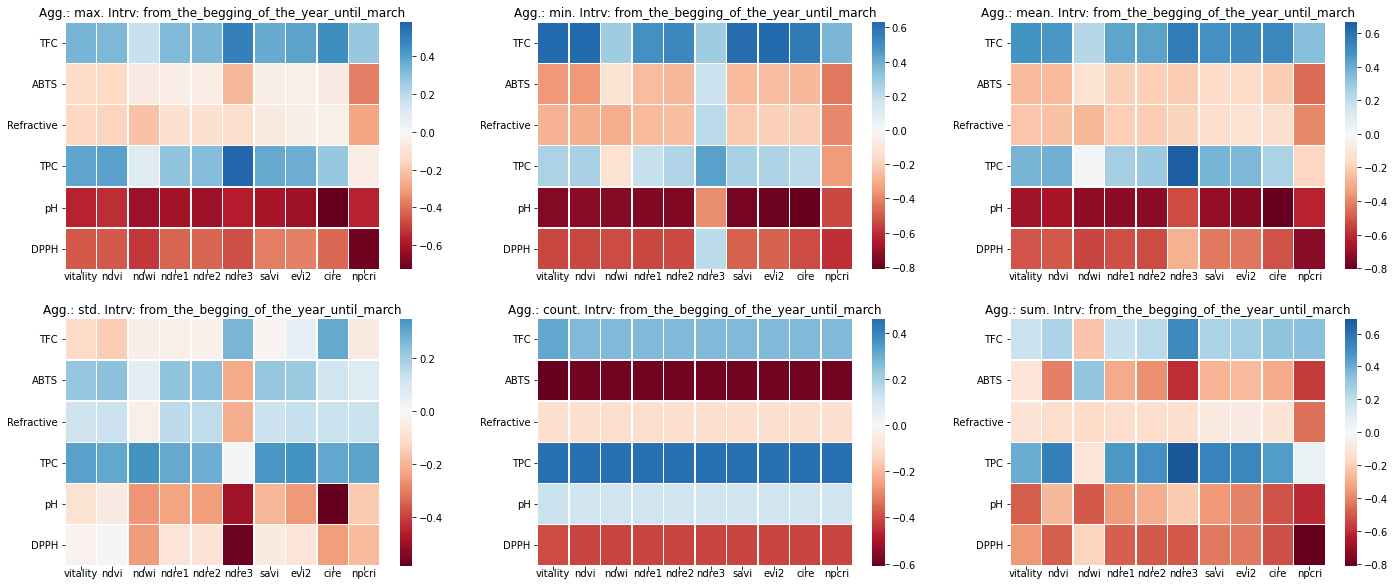

interval_from_the_begging_of_the_year_until_april


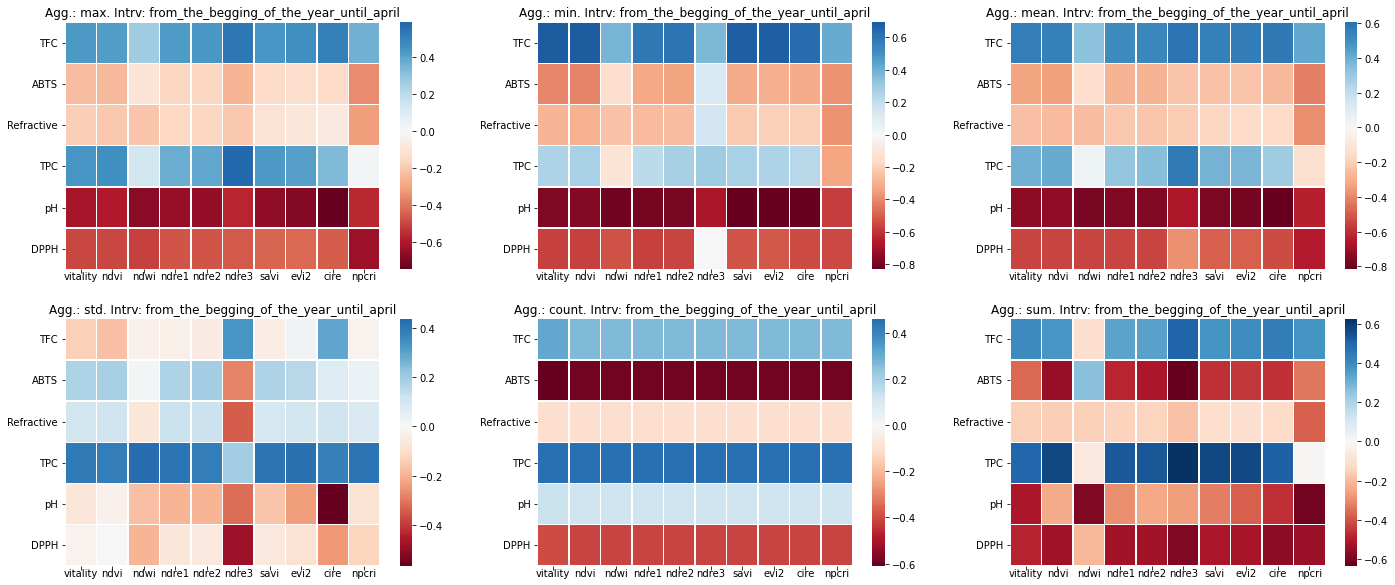

interval_from_the_begging_of_the_year_until_may


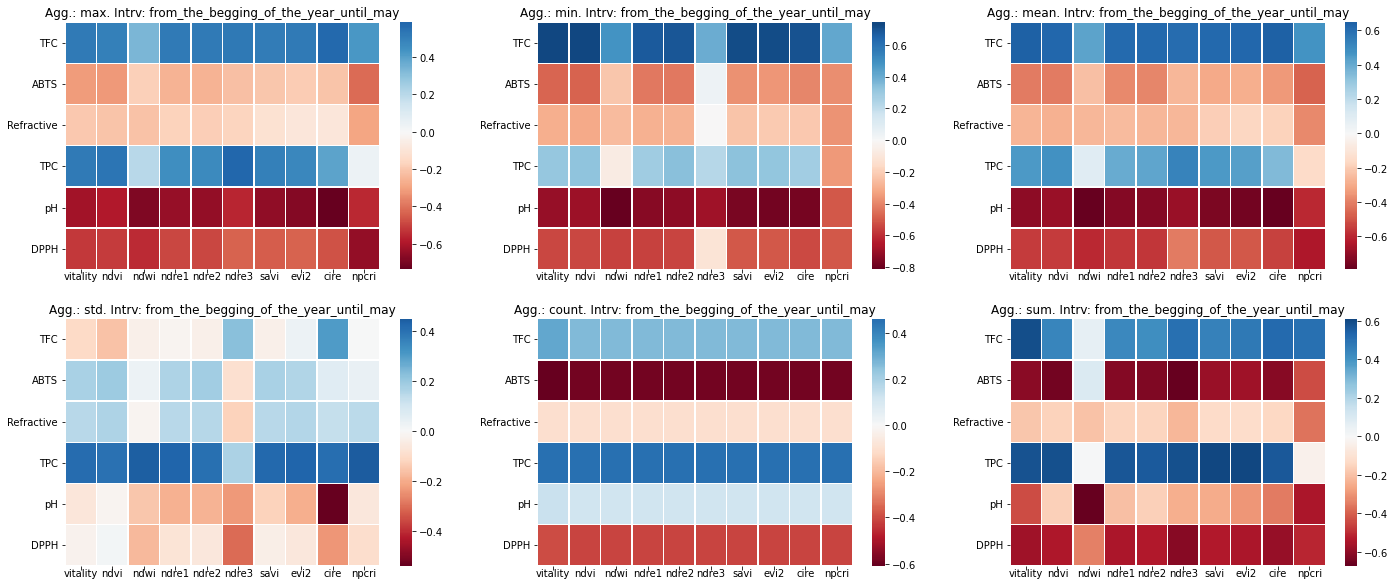

interval_from_the_begging_of_the_year_until_june


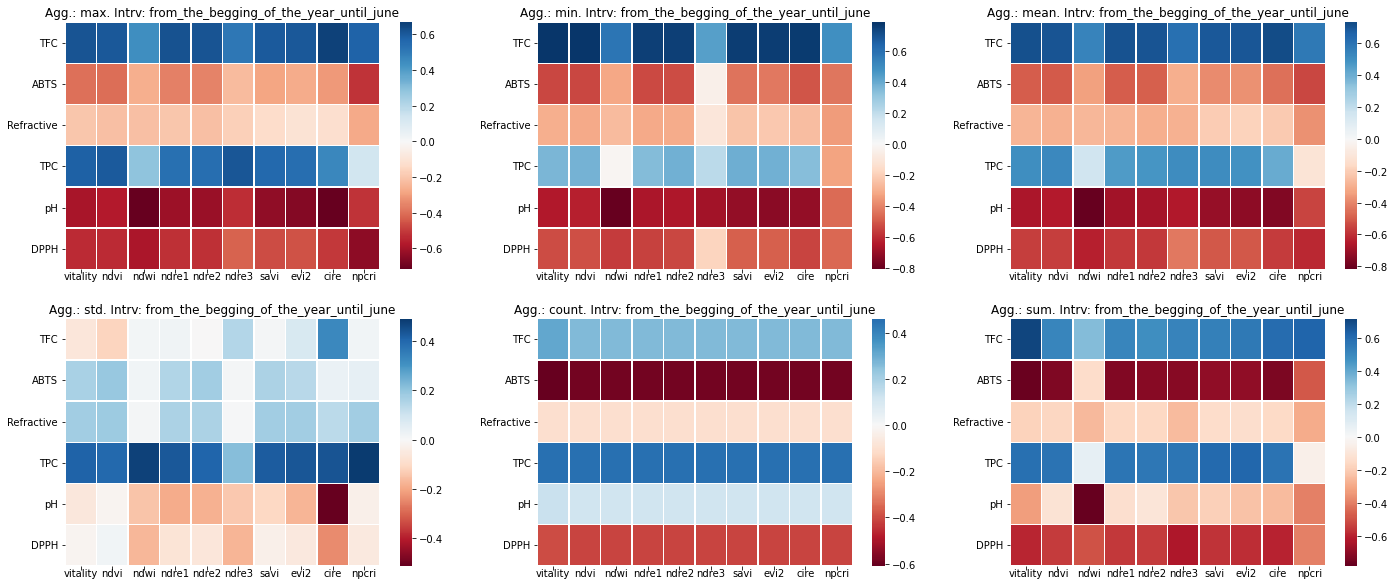

In [16]:
###  @parameters 
list_of_agg_value_columns = ['max', 'min', 'mean', 'std', 'count', 'sum']
list_of_agg_time_functions = [interval_from_the_begging_of_the_year_until_march, 
                interval_from_the_begging_of_the_year_until_april, 
                interval_from_the_begging_of_the_year_until_may, 
                interval_from_the_begging_of_the_year_until_june]

for agg_time_function in list_of_agg_time_functions:
    plt.figure(figsize=(24,10))
    idx_plot = 1
    print(agg_time_function.__name__)
    for agg_value_column in list_of_agg_value_columns:
        correlation_matrix, x_labels, y_labels = fn_correlation_matrix(agg_value_column, agg_time_function, satellite_source, verbose=False)
        # plot 
        plot_title = "Agg.: {}. Intrv: {}".format(agg_value_column, agg_time_function.__name__.replace("interval_", ""))        
        plot_heat_map(correlation_matrix, x_labels, y_labels, plot_title, (2,3), idx_plot)
        idx_plot = idx_plot + 1
        
    plt.show()


## RQ. What are the most correlated satellite imagery indexes for each maceration property?

In [17]:
list_of_agg_value_columns = ['max', 'min', 'mean', 'std', 'count', 'sum']
list_of_agg_time_functions = [interval_from_the_begging_of_the_year_until_march, 
                interval_from_the_begging_of_the_year_until_april, 
                interval_from_the_begging_of_the_year_until_may, 
                interval_from_the_begging_of_the_year_until_june]

df_highest_corr = None
for agg_value_column in list_of_agg_value_columns:
    for agg_time_function in list_of_agg_time_functions:
        correlation_matrix, x_labels, y_labels = fn_correlation_matrix(agg_value_column, agg_time_function, satellite_source, verbose=False) # fn_correlation_matrix(agg_function, satellite_source, days_before_the_crop, verbose=False)
        df_result = get_the_most_correlated_variables(correlation_matrix, x_labels, y_labels)
        df_result['Agg_value_column'] = agg_value_column
        df_result['Agg_time_function'] = agg_time_function.__name__
        df_result['Source'] = satellite_source
        
        if df_highest_corr is None:
            df_highest_corr = df_result
        else:
            df_highest_corr = pd.concat([df_highest_corr, df_result])

                        
pd.set_option('max_colwidth', 800)
df_highest_corr_by_ba = df_highest_corr.sort_values(by=[type_analysis, 'Highest_Corr_Value_Abs'], ascending=False)
df_highest_corr_by_ba = df_highest_corr_by_ba.drop_duplicates(subset=[type_analysis], keep='first')
df_highest_corr_by_ba.rename(columns={'Product_Type':'Most_correlated_Product_Type'}, inplace=True)
df_highest_corr_by_ba[[type_analysis, 'Most_correlated_Product_Type', 'Highest_Corr_Value', 'Highest_Corr_Value_Abs','Agg_time_function', 'Agg_value_column', 'Source']]
df_highest_corr_by_ba = df_highest_corr_by_ba[[type_analysis, 'Most_correlated_Product_Type', 'Highest_Corr_Value', 'Highest_Corr_Value_Abs','Agg_time_function', 'Agg_value_column']]
df_highest_corr_by_ba
            

,Maceration,Most_correlated_Product_Type,Highest_Corr_Value,Highest_Corr_Value_Abs,Agg_time_function,Agg_value_column
4,pH,evi2,-0.831473,0.831473,interval_from_the_begging_of_the_year_until_april,min
3,TPC,ndre3,0.690595,0.690595,interval_from_the_begging_of_the_year_until_march,sum
0,TFC,vitality,0.786551,0.786551,interval_from_the_begging_of_the_year_until_june,min
2,Refractive,npcri,-0.444023,0.444023,interval_from_the_begging_of_the_year_until_march,sum
5,DPPH,npcri,-0.813996,0.813996,interval_from_the_begging_of_the_year_until_march,sum
1,ABTS,vitality,-0.769895,0.769895,interval_from_the_begging_of_the_year_until_june,sum


## RQ. What are the most correlated maceration properties for each satellite imagery index?

In [18]:
pd.set_option('max_colwidth', 800)

df_highest_corr_by_Satellity_Index = df_highest_corr.sort_values(by=['Product_Type', 'Highest_Corr_Value_Abs'], ascending=False)
df_highest_corr_by_Satellity_Index = df_highest_corr_by_Satellity_Index.drop_duplicates(subset=['Product_Type'], keep='first')
df_highest_corr_by_Satellity_Index.rename(columns={type_analysis:'Most_correlated_{0}_Prop'.format(type_analysis)}, inplace=True)
df_highest_corr_by_Satellity_Index[['Product_Type', 'Most_correlated_{0}_Prop'.format(type_analysis), 'Highest_Corr_Value', 'Highest_Corr_Value_Abs', 'Agg_time_function', 'Agg_value_column', 'Source']]


df_highest_corr_by_Satellity_Index = df_highest_corr_by_Satellity_Index[['Product_Type', 'Most_correlated_{0}_Prop'.format(type_analysis), 'Highest_Corr_Value', 'Highest_Corr_Value_Abs', 'Agg_time_function', 'Agg_value_column']]
df_highest_corr_by_Satellity_Index

,Product_Type,Most_correlated_Maceration_Prop,Highest_Corr_Value,Highest_Corr_Value_Abs,Agg_time_function,Agg_value_column
0,vitality,TFC,0.786551,0.786551,interval_from_the_begging_of_the_year_until_june,min
3,savi,TPC,0.393863,0.393863,interval_from_the_begging_of_the_year_until_june,min
5,npcri,DPPH,-0.813996,0.813996,interval_from_the_begging_of_the_year_until_march,sum
4,ndwi,pH,-0.818572,0.818572,interval_from_the_begging_of_the_year_until_june,mean
5,ndvi,DPPH,-0.566751,0.566751,interval_from_the_begging_of_the_year_until_april,min
3,ndre3,TPC,0.690595,0.690595,interval_from_the_begging_of_the_year_until_march,sum
1,ndre2,ABTS,0.243516,0.243516,interval_from_the_begging_of_the_year_until_march,std
5,ndre1,DPPH,-0.557829,0.557829,interval_from_the_begging_of_the_year_until_may,min
4,evi2,pH,-0.831473,0.831473,interval_from_the_begging_of_the_year_until_april,min
4,cire,pH,-0.817427,0.817427,interval_from_the_begging_of_the_year_until_april,mean
